In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# --- 1. Settings ---

In [2]:
# Ensure the working directory is set correctly
# Replace with the actual path to your project directory if different
# script_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/scMulti_merged_matrix"
script_dir = "D:/Github/scMulti_merged_matrix"
os.chdir(script_dir)
print(f"Working directory set to: {script_dir}")

target_gene = 'Rbfox3'

Working directory set to: D:/Github/scMulti_merged_matrix


In [3]:
# Set Scanpy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)
fig_dir = os.path.join(script_dir, 'figures_rbfox3')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
sc.settings.figdir = fig_dir
print(f"Figure directory set to: {fig_dir}")

Figure directory set to: D:/Github/scMulti_merged_matrix\figures_rbfox3


# --- 2. Load Processed Data ---

In [4]:
print("Loading processed data...")
adata_file = 'processed_data.h5ad'
if not os.path.exists(adata_file):
    raise FileNotFoundError(f"The file {adata_file} was not found in {script_dir}. "
                          "Please ensure the 'process_sc_data.py' script has been run successfully.")
adata = sc.read_h5ad(adata_file)
print("Processed data loaded successfully.")
print(adata)

Loading processed data...
Processed data loaded successfully.
AnnData object with n_obs × n_vars = 9800 × 3623
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'LibraryID'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_csv'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


# --- 3. Analyze RBFOX3 Expression ---

In [5]:
print(f"\n--- Analyzing expression of {target_gene} ---")

# Ensure 'leiden' clustering is present
if 'leiden' not in adata.obs.columns:
    print("WARNING: 'leiden' clustering not found in adata.obs. Performing default Leiden clustering.")
    # Perform Leiden clustering if not present (optional, or raise error)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # Ensure neighbors are computed
    sc.tl.leiden(adata)
    print("Leiden clustering performed.")


--- Analyzing expression of Rbfox3 ---


## 4.1. UMAP Visualization


Creating UMAP plot for Rbfox3 expression...


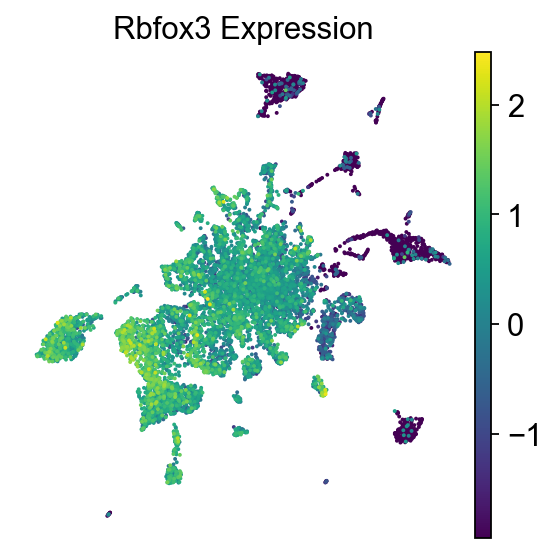


Creating UMAP plot (CSV coordinates) for Rbfox3 expression...


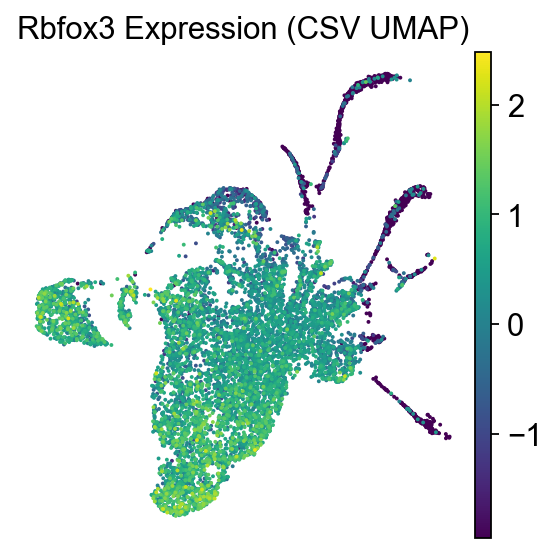

In [6]:
print(f"\nCreating UMAP plot for {target_gene} expression...")
sc.pl.umap(adata, color=target_gene, 
            save=f'_umap_{target_gene}_expression.png',
            title=f'{target_gene} Expression',
            show=True)

# Also plot on X_umap_csv if available
if 'X_umap_csv' in adata.obsm.keys():
    print(f"\nCreating UMAP plot (CSV coordinates) for {target_gene} expression...")
    sc.pl.embedding(adata, basis='X_umap_csv', color=target_gene,
                    save=f'_umap_csv_{target_gene}_expression.png',
                    title=f'{target_gene} Expression (CSV UMAP)',
                    show=True)

## 4.2. Expression by Cluster


Creating dot plot for Rbfox3 expression by Leiden cluster...


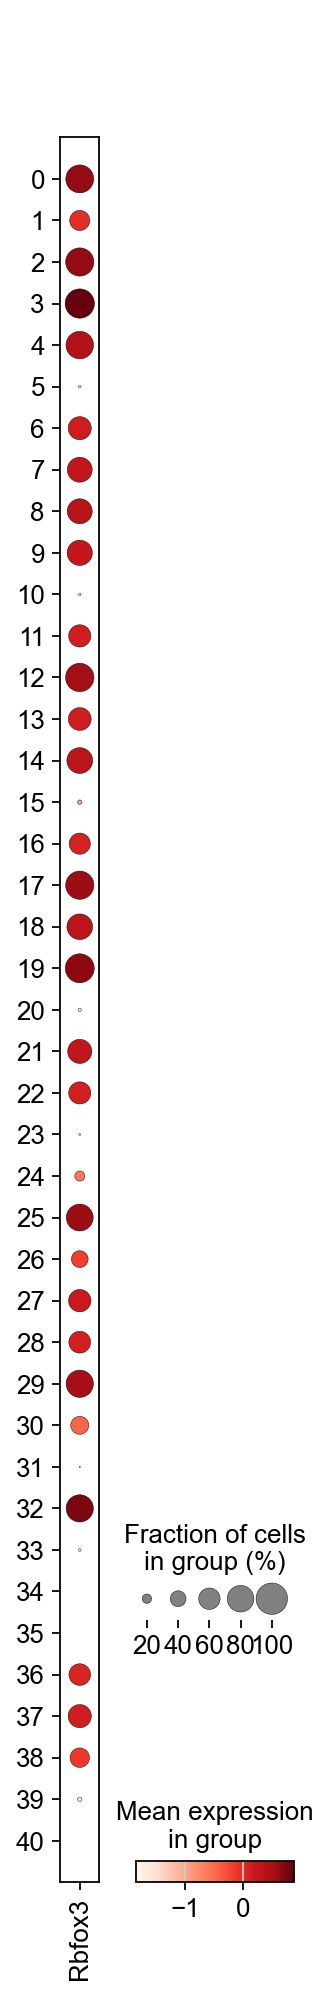

In [7]:
print(f"\nCreating dot plot for {target_gene} expression by Leiden cluster...")
sc.pl.dotplot(adata, [target_gene], groupby='leiden',
                save=f'_dotplot_{target_gene}_leiden.png',
                show=True)


Creating violin plot for Rbfox3 expression by Leiden cluster...


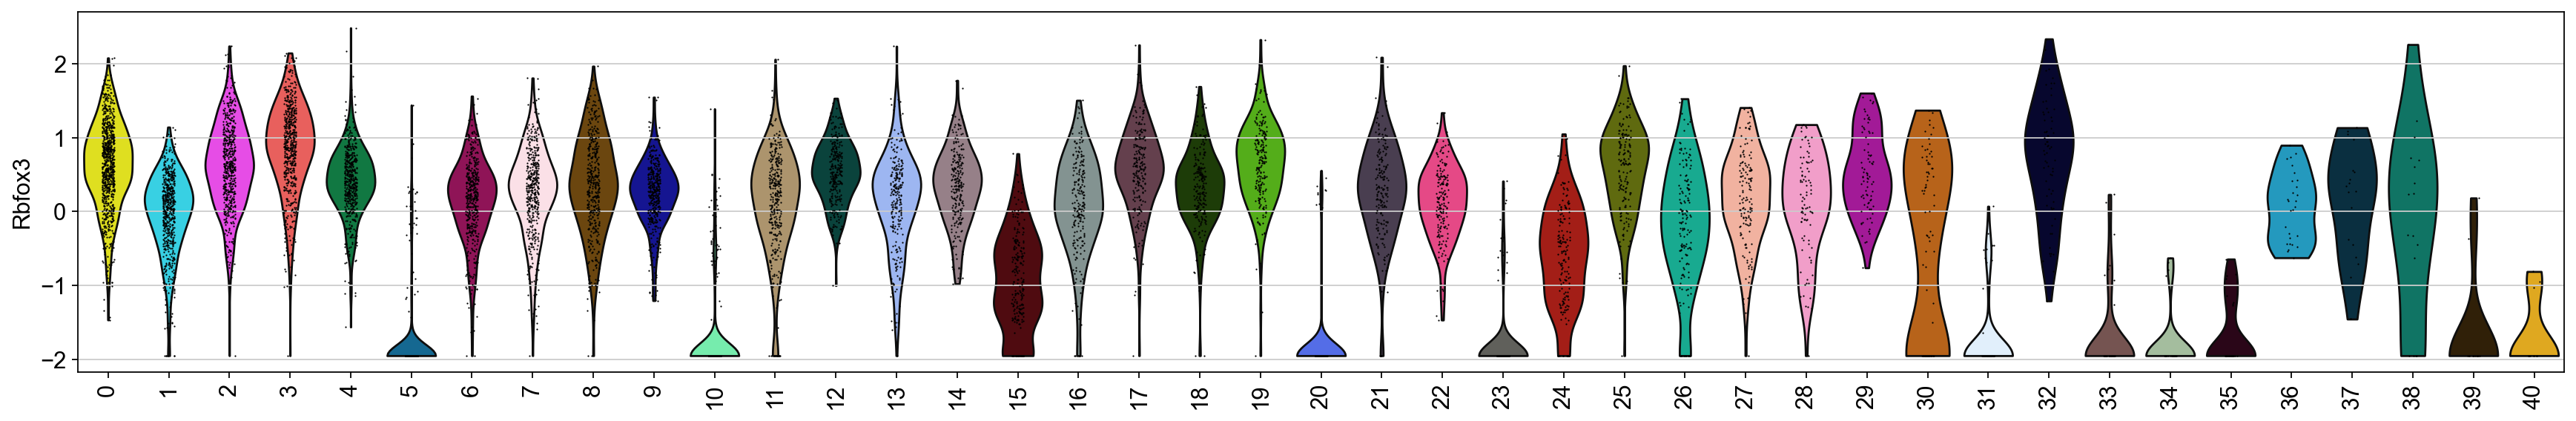

In [8]:
print(f"\nCreating violin plot for {target_gene} expression by Leiden cluster...")
sc.settings.set_figure_params(figsize=(max(6, adata.obs['leiden'].nunique()*0.5), 4), dpi=80) # Adjust width based on number of clusters
sc.pl.violin(adata, [target_gene], groupby='leiden',
                save=f'_violin_{target_gene}_leiden.png',
                show=True, rotation=90)
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False) # Reset fig params

## 4.3. Summary Statistics

In [9]:
print(f"\nExpression summary statistics for {target_gene}:")

gene_expr_overall = adata[:, target_gene].X.toarray().flatten()
expressing_cells_overall = (gene_expr_overall > 0).sum()
total_cells_overall = len(gene_expr_overall)
mean_expr_overall = gene_expr_overall.mean()
mean_expr_in_expressing_overall = gene_expr_overall[gene_expr_overall > 0].mean() if expressing_cells_overall > 0 else 0
max_expr_overall = gene_expr_overall.max()

print("\nOverall Dataset:")
print(f"  Cells expressing {target_gene}: {expressing_cells_overall}/{total_cells_overall} ({100*expressing_cells_overall/total_cells_overall:.1f}%)")
print(f"  Mean expression (all cells): {mean_expr_overall:.3f}")
print(f"  Mean expression (expressing cells only): {mean_expr_in_expressing_overall:.3f}")
print(f"  Max expression: {max_expr_overall:.3f}")

if 'leiden' in adata.obs.columns:
    print("\nBy Leiden Cluster:")
    for cluster in sorted(adata.obs['leiden'].cat.categories):
        adata_cluster = adata[adata.obs['leiden'] == cluster, :]
        gene_expr_cluster = adata_cluster[:, target_gene].X.toarray().flatten()
        expressing_cells_cluster = (gene_expr_cluster > 0).sum()
        total_cells_cluster = len(gene_expr_cluster)
        mean_expr_cluster = gene_expr_cluster.mean()
        mean_expr_in_expressing_cluster = gene_expr_cluster[gene_expr_cluster > 0].mean() if expressing_cells_cluster > 0 else 0
        max_expr_cluster = gene_expr_cluster.max()

        print(f"  Cluster {cluster}:")
        print(f"    Cells expressing {target_gene}: {expressing_cells_cluster}/{total_cells_cluster} ({100*expressing_cells_cluster/total_cells_cluster:.1f}%)")
        print(f"    Mean expression (all cells): {mean_expr_cluster:.3f}")
        print(f"    Mean expression (expressing cells only): {mean_expr_in_expressing_cluster:.3f}")
        print(f"    Max expression: {max_expr_cluster:.3f}")


Expression summary statistics for Rbfox3:

Overall Dataset:
  Cells expressing Rbfox3: 6069/9800 (61.9%)
  Mean expression (all cells): -0.000
  Mean expression (expressing cells only): 0.636
  Max expression: 2.485

By Leiden Cluster:
  Cluster 0:
    Cells expressing Rbfox3: 746/874 (85.4%)
    Mean expression (all cells): 0.621
    Mean expression (expressing cells only): 0.790
    Max expression: 2.078
  Cluster 1:
    Cells expressing Rbfox3: 324/590 (54.9%)
    Mean expression (all cells): -0.032
    Mean expression (expressing cells only): 0.350
    Max expression: 1.142
  Cluster 10:
    Cells expressing Rbfox3: 12/368 (3.3%)
    Mean expression (all cells): -1.757
    Mean expression (expressing cells only): 0.346
    Max expression: 1.390
  Cluster 11:
    Cells expressing Rbfox3: 216/342 (63.2%)
    Mean expression (all cells): 0.125
    Mean expression (expressing cells only): 0.541
    Max expression: 2.059
  Cluster 12:
    Cells expressing Rbfox3: 241/276 (87.3%)
    Me

In [10]:
print("\n--- RBFOX3 Analysis Script Finished ---") 


--- RBFOX3 Analysis Script Finished ---
